In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import json

In [20]:
# Path to experiment folder
experiment_folder = "../data/experiment-i"
subject_folders = sorted(glob.glob(os.path.join(experiment_folder, "S*")))  # e.g., "S1", "S2", etc.

# Dictionary to store data: {subject: {posture: frames}}
subject_posture_data = {}

for subject in subject_folders:
    subject_id = os.path.basename(subject)  # e.g., "S1"
    subject_posture_data[subject_id] = {}  # Initialize subject dictionary

    # Find all posture .txt files (e.g., "1.txt", "2.txt", etc.)
    txt_files = sorted(glob.glob(os.path.join(subject, "*.txt")))

    for txt_file in txt_files:
        posture_id = os.path.splitext(os.path.basename(txt_file))[0]  # Extract posture name (e.g., "1", "2")

        # Manually read and clean the file
        cleaned_data = []
        with open(txt_file, "r") as f:
            for line in f:
                line = line.strip()
                if line and not any(c.isalpha() for c in line):  # Ignore empty lines and non-numeric separators
                    cleaned_data.append([float(x) for x in line.split("\t")])  # Convert valid numeric data

        # Convert to NumPy array
        data = np.array(cleaned_data)

        # **Convert raw values (0-1000) to mmHg (0-100)**
        data = data * 0.1  # Apply conversion factor

        # Compute the number of frames
        total_values = data.size
        num_frames = total_values // (32 * 64)

        frames = data[: num_frames * 64 * 32].reshape(num_frames, 64, 32)
        frames = frames[2:]  # Only start at frame 3

        # Store frames under subject -> posture
        subject_posture_data[subject_id][posture_id] = frames


In [21]:
subject_posture_data.keys()

dict_keys(['S1', 'S10', 'S11', 'S12', 'S13', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9'])

In [4]:
# Print the structure of loaded data
for subject, postures in subject_posture_data.items():
    print(f"{subject}:")
    for posture, frames in postures.items():
        print(f"  Posture {posture}: {frames.shape[0]} frames")

S1:
  Posture 1: 80 frames
  Posture 10: 71 frames
  Posture 11: 78 frames
  Posture 12: 73 frames
  Posture 13: 79 frames
  Posture 14: 74 frames
  Posture 15: 91 frames
  Posture 16: 79 frames
  Posture 17: 88 frames
  Posture 2: 68 frames
  Posture 3: 88 frames
  Posture 4: 67 frames
  Posture 5: 76 frames
  Posture 6: 67 frames
  Posture 7: 67 frames
  Posture 8: 70 frames
  Posture 9: 72 frames
S10:
  Posture 1: 80 frames
  Posture 10: 70 frames
  Posture 11: 68 frames
  Posture 12: 77 frames
  Posture 13: 74 frames
  Posture 14: 77 frames
  Posture 15: 73 frames
  Posture 16: 82 frames
  Posture 17: 79 frames
  Posture 2: 66 frames
  Posture 3: 77 frames
  Posture 4: 76 frames
  Posture 5: 70 frames
  Posture 6: 86 frames
  Posture 7: 70 frames
  Posture 8: 73 frames
  Posture 9: 105 frames
S11:
  Posture 1: 92 frames
  Posture 10: 69 frames
  Posture 11: 66 frames
  Posture 12: 66 frames
  Posture 13: 73 frames
  Posture 14: 65 frames
  Posture 15: 75 frames
  Posture 16: 66 fra

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pose_comparison(pose1_id, pose2_id, levels=15):
    """
    Plots a side-by-side contour map comparing the average pressure distribution 
    of two postures with identical contour levels.

    Parameters:
        pose1_id (str): Posture identifier for the first pose 
        pose2_id (str): Posture identifier for the second pose 
        levels (int): Number of contour levels (default is 15)
    """
    
    all_frames_pose1, all_frames_pose2 = [], []


    # Collect frames for Pose 1
    for subject, postures in subject_posture_data.items():
        if pose1_id in postures:
            all_frames_pose1.append(postures[pose1_id])  # Shape: (num_frames, 32, 64)

    # Collect frames for Pose 2
    for subject, postures in subject_posture_data.items():
        if pose2_id in postures :
            all_frames_pose2.append(postures[pose2_id])  # Shape: (num_frames, 32, 64)

    if all_frames_pose1 and all_frames_pose2:
        # Find minimum frame count across subjects for both postures
        min_frames_pose1 = min(f.shape[0] for f in all_frames_pose1)
        min_frames_pose2 = min(f.shape[0] for f in all_frames_pose2)

        # Trim all subject data to have the same frame count
        trimmed_pose1 = [f[:min_frames_pose1] for f in all_frames_pose1]
        trimmed_pose2 = [f[:min_frames_pose2] for f in all_frames_pose2]

        # Compute average pressure map for each posture
        avg_pose1 = np.mean(np.array(trimmed_pose1), axis=(0, 1))  # Mean over subjects and frames
        avg_pose2 = np.mean(np.array(trimmed_pose2), axis=(0, 1))  # Mean over subjects and frames

        pose1json = json.dumps(avg_pose1.tolist())
        pose2json = json.dumps(avg_pose2.tolist())

        # Find global min/max for consistent color scale
        vmin = min(avg_pose1.min(), avg_pose2.min())
        vmax = max(avg_pose1.max(), avg_pose2.max())

        # Generate identical contour levels
        contour_levels = np.linspace(vmin, vmax, levels)

        # Generate side-by-side contour plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 12))

        # Contour Plot for Pose 1
        X, Y = np.meshgrid(np.arange(avg_pose1.shape[1]), np.arange(avg_pose1.shape[0]))
        contour1 = axes[0].contourf(X, Y, avg_pose1, levels=contour_levels, cmap='RdGy_r', vmin=vmin, vmax=vmax)
        axes[0].set_title('Sleeping on the Back')
        axes[0].set_xlabel('Width')
        axes[0].set_ylabel('Height')
        axes[0].invert_yaxis()
        axes[0].tick_params(colors='white')

        # Contour Plot for Pose 2
        contour2 = axes[1].contourf(X, Y, avg_pose2, levels=contour_levels, cmap='RdGy_r', vmin=vmin, vmax=vmax)
        axes[1].set_title(f'Sleeping on the Left')
        axes[1].set_xlabel('Width')
        axes[1].invert_yaxis()
        axes[1].tick_params(colors='white')

        # Common colorbar for both plots with white font
        cbar = fig.colorbar(contour2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label('Pressure', color='white')
        cbar.ax.yaxis.set_tick_params(color='white')  # Change tick color
        plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')  # Change tick label color

        # Set white text for the entire figure
        
        plt.suptitle(f'Pressure Comparison: Posture {pose1_id} vs. Posture {pose2_id} (Same Contour Levels)', color='white')
        plt.tight_layout()
        plt.show()

        return pose1json, pose2json

    else:
        print(f"Not enough data found for Posture {pose1_id} or Posture {pose2_id}.")

/var/folders/z2/vph283tj4zl_xlvz69kq7hfh0000gn/T/ipykernel_7706/1395632519.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


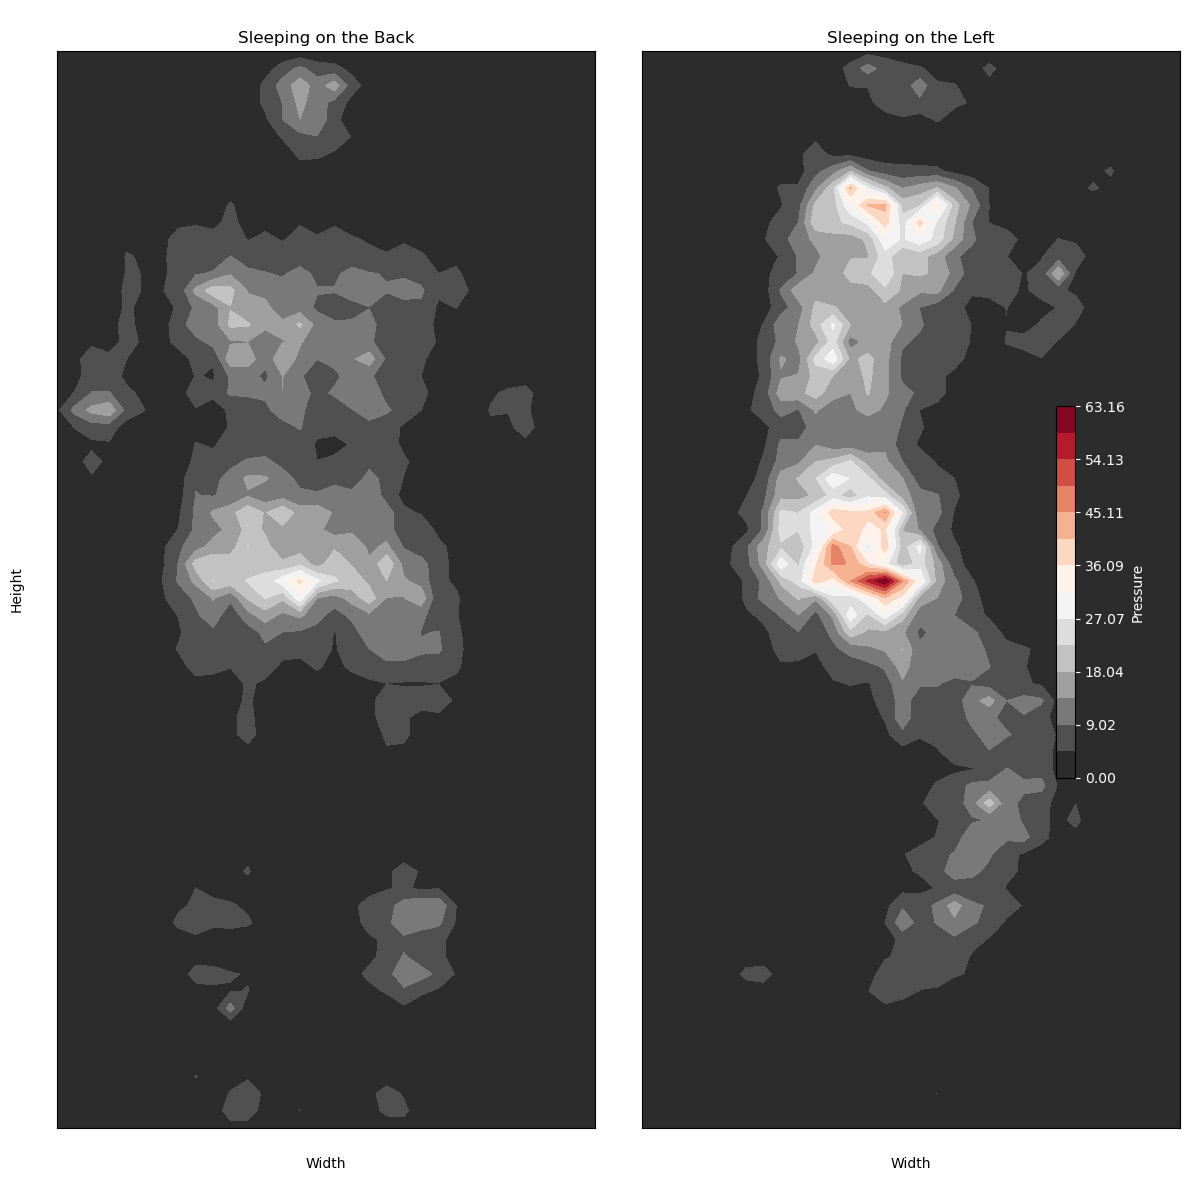

In [32]:
pose1json, pose2json = plot_pose_comparison(pose1_id="1", pose2_id="2")


In [33]:
pose1json

'[[0.07443438914027137, 0.04920814479638035, 0.03201357466063344, 0.1458144796380086, 0.12635746606334822, 0.15237556561085974, 0.29728506787330317, 0.5156108597285078, 0.3518099547511322, 0.25791855203619857, 0.34558823529411725, 0.3104072398190035, 0.3280542986425342, 0.6825791855203629, 0.999095022624431, 0.9042986425339355, 1.0700226244343882, 0.8001131221719459, 0.27760180995475103, 0.18495475113122187, 0.1701357466063348, 0.0860859728506787, 0.15373303167420818, 0.10056561085972851, 0.04819004524886878, 0.040158371040724034, 0.02228506787330317, 0.06990950226244337, 0.05384615384615388, 0.04389140271493217, 0.001018099547511312, 0.027262443438914086], [0.14174208144796402, 0.12239819004524909, 0.07115384615384623, 0.09581447963800899, 0.19886877828054256, 0.13325791855203603, 0.339819004524885, 0.8563348416289592, 0.6414027149321279, 0.2886877828054285, 0.7976244343891382, 0.8261312217194581, 2.3842760180995337, 6.576583710407242, 10.154298642533956, 6.7165158371040645, 5.7628959

In [8]:
experiment_folder

'../data/experiment-i'

In [12]:
info = pd.read_csv(experiment_folder + '/subject-info-i.csv', encoding="utf-16")
info.head()

,Subject-Number,Age,Height/cm,Weight/kg
0,1,19,175,87
1,2,23,183,85
2,3,23,183,100
3,4,24,177,70
4,5,24,172,66


In [13]:
info['BMI'] =  info['Weight/kg'] / ((info['Height/cm'] / 100)**2)

def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal weight"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obesity"

# Apply the function to the BMI column
info['BMI Category'] = info['BMI'].apply(categorize_bmi)

In [14]:
info['Subject-Number'] = info['Subject-Number'].apply(lambda a: 'S' + str(a))
info

,Subject-Number,Age,Height/cm,Weight/kg,BMI,BMI Category
0,S1,19,175,87,28.408163,Overweight
1,S2,23,183,85,25.381469,Overweight
2,S3,23,183,100,29.860551,Overweight
3,S4,24,177,70,22.343516,Normal weight
4,S5,24,172,66,22.309356,Normal weight
5,S6,26,169,83,29.060607,Overweight
6,S7,27,179,96,29.961612,Overweight
7,S8,27,186,63,18.210198,Underweight
8,S9,30,174,74,24.441802,Normal weight
9,S10,30,174,79,26.093275,Overweight
